In [1]:
# import json
# import pandas as pd

https://github.com/langchain-ai/langgraph-supervisor-py

https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/

In [2]:
# pip install --upgrade langgraph-supervisor

### auth

dIIzpurt токен

In [3]:
auth_project='=='

мой токен

In [4]:
auth_personal='=='

### базовые LLM

In [5]:
from langchain_gigachat import GigaChat

from langchain_core.messages import HumanMessage, SystemMessage

model_lite = GigaChat(credentials=auth_personal, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat',
               temperature=0.00)

model_pro = GigaChat(credentials=auth_project, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat-Pro',
               temperature=0.00)

model_max = GigaChat(credentials=auth_project, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat-Max',
               temperature=0.00)

llm_db = GigaChat(credentials=auth_project, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat-Max',
               temperature=0.00)

### SQLDatabase Для Агента1

### Промпт

In [6]:
from langchain_core.prompts import PromptTemplate

template = '''You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run,
then look at the results of the query and return the answer.

Выводи в ответе ТОЛЬКО SQL запрос.

Если не уточняется, выведи первые {top_k} строк.

Only use the following tables:
{table_info}.

Используй следующую информацию о таблицах:
application: информация о заявках на ипотеку
client: информация о клиентах, подававших заявки на ипотеку. Клиенты с client_num=0 - основные заемщики. 1, 2 и т.д. - созаемщики
decision: информация о принятом решении по кредиту. 1 - ипотека одобрена, 0 - отклонена
product: справочник категорий ипотечных продуктов
subproduct: справочник подкатегорий ипотечных продуктов
application_category: к какой категории относятся заемщики
channel: справочник каналов, по которым пришел заемщик
reject_rule: справочник причин отказов
territory_bank: справочник территориальных банков

Учитывай, что на вопросы, связанные с одобрением заявок необходимо делать join на таблицу decision

Question: {input}'''

tables = [
    "application",
    "client",
    "decision",
    "product",
    "subproduct",
    "application_category",
    "channel",
    "reject_rule",
    "territory_bank"
]

prompt_db = PromptTemplate.from_template(template, table_info=tables)

In [7]:
db_path = 'db_mortgage.db'
import sqlite3

conn = sqlite3.connect(db_path)
cur = conn.cursor()

from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///" + db_path)
from langchain.chat_models.gigachat import GigaChat


from langchain.chains import create_sql_query_chain
chain_db = create_sql_query_chain(llm_db, db, prompt=prompt_db)

# Строим граф

In [8]:
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

## Create specialized agents

### Database агент

In [68]:
def database_func(user_question: str) -> str:
    """На основе заданного вопроса сформируй SQL запрос, выполни и ответь на поставленный вопрос"""
    print('+'*100)
    print(user_question)
    response = chain_db.invoke({"question": user_question})
    print(response)

    response_table = db.run(response[7:-5], include_columns=True)
    
    print(response_table)
    
    aaa = model_pro.invoke(
        "Я приведу тебе: " + 
        "1. Вопрос пользователя " + 
        "2. SQL запрос, который был сформирован чтобы ответить на вопрос пользователя. " + 
        "3. Ответ базы данных на этот SQL запрос. " + 
        "Сопоставь вопрос пользователя с ответом ответ БД и напиши текстом, как бы человек ответил на изначально поставленный запрос пользователя. " + 
        "Итак: " + 
        "1. Вопрос пользователя: " + user_question + 
        "2. SQL запрос: " + response[7:-5] + 
        "3. Ответ базы данных: " + db.run(response[7:-5]) + 
        " . Приведи только ответ пользователя от его лица"
        )
    
    print(aaa.content)
    # df = pd.read_sql_query(response[7:-5], conn)
    # print(df)
    print('+'*100)
    answer = 'Готово: ' + aaa.content + '. Данные на которых получен ответ: ' + response_table
    print(answer)
    return answer

database_agent = create_react_agent(
    model=model_pro,
    tools=[database_func],
    name="database_expert",
    # prompt="You are agent who interact with Database to answer questions. ALWAYS use tool for tasks"
    prompt="""Ты агент, который взаимодействует с Базой данных по ипотечным заявкам для ответа на пользовательские вопросы. 
    ВСЕГДА используй для работы tools. Результат работы tools возвращай агенту-руководителю ответ целиком как есть, НЕ СОКРАЩАЙ ОТВЕТ и не добавляй ничего"""

)

### Агент аналитик

In [69]:
analyst_agent = create_react_agent(
    model=model_pro,
    tools=[],
    name="analyst_expert",
    # prompt="You are agent who interact with Database to answer questions. ALWAYS use tool for tasks"
    prompt="""Ты высококласный аналитик, который анализирует данные. Ты должен использовать ТОЛЬКО те данные, которые ранее были получены в диалоге."""
)

### Агент Supervisor

In [70]:
# Create supervisor workflow
workflow = create_supervisor(
    [database_agent, analyst_agent],
    model=model_max,
    prompt=(
        "Ты агент-руководитель, который управляет агентами database_expert и analyst_expert. "
        "НИ В КОЕМ СЛУЧАЕ не бращайся к database_agent или analyst_expert БОЛЕЕ ОДНОГО РАЗА"
        
        "Ключевые фразы для database_agent: 'сколько', 'какой процент', 'найди', 'выведи', ' ответь в разрезе' "
        "Ключевые фразы для analyst_agent: 'проанализируй', 'аномалии', 'сделай выводы' "
        
        "Для агента database_agent перенаправляй пользовательские вопросы целиком как есть. "
        "Результат работы database_agent СРАЗУ верни пользователю целиком как есть, сам ничего не выдумывай, не добавляй и не отрезай от ответа"
        "НИ В КОЕМ СЛУЧАЕ не обращайся к database_expert более одного раза"

        "Для агента analyst_agent перенаправляй пользовательские вопросы целиком как есть. "
        "Результат работы analyst_agent СРАЗУ верни пользователю целиком как есть, сам ничего не выдумывай, не добавляй и не отрезай от ответа"

        "Заверши workflow, после того как какой-нибудь агент скажет 'Готово ...' "
        
    )
)

In [71]:
# Compile and run
app = workflow.compile()

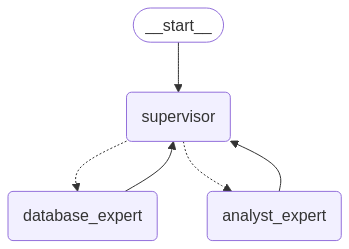

In [42]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

### Вызовы без памяти

In [72]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Верни среднюю ставку по одобренным заявкам в разрезе по месяцам за последние пол года"
        }
    ]
})

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Верни среднюю ставку по одобренным заявкам в разрезе по месяцам за последние пол года
```sql
SELECT 
    STRFTIME('%Y-%m', application_dt) AS month, 
    AVG(interest_rate) AS average_interest_rate
FROM 
    application
JOIN 
    decision ON application.application_num = decision.application_num AND decision.decision = 1
WHERE 
    application_dt >= DATE('now', '-6 months')
GROUP BY 
    STRFTIME('%Y-%m', application_dt);
```
[{'month': '2024-09', 'average_interest_rate': 11.986666666666666}, {'month': '2024-10', 'average_interest_rate': 15.425}, {'month': '2024-11', 'average_interest_rate': 18.23}, {'month': '2024-12', 'average_interest_rate': 11.97}, {'month': '2025-01', 'average_interest_rate': 16.754444444444445}, {'month': '2025-02', 'average_interest_rate': 20.583333333333332}]
Средняя ставка по одобренным заявкам за последние полгода составила 16,75%.
++++++++++++++++++++++++++++

In [73]:
len(result['messages'])

7

In [74]:
for i in result['messages']:
    print(i)
    print('='*100)

content='Верни среднюю ставку по одобренным заявкам в разрезе по месяцам за последние пол года' additional_kwargs={} response_metadata={} id='e9ef411f-078a-47f4-8b88-769ce510db6b'
content='' additional_kwargs={'function_call': {'name': 'transfer_to_database_expert', 'arguments': {'query': 'Верни среднюю ставку по одобренным заявкам в разрезе по месяцам за последние пол года'}}, 'functions_state_id': '2466a3fc-53fd-4d5b-b906-8b301568ccc5'} response_metadata={'token_usage': {'prompt_tokens': 67, 'completion_tokens': 41, 'total_tokens': 108}, 'model_name': 'GigaChat-Max:1.0.26.20', 'x_headers': {'x-request-id': 'ce4efa8f-cfd6-41b7-9d1e-55a821251dd8', 'x-session-id': 'c2163efc-fabc-4b5f-9663-f3625f60a4d3', 'x-client-id': None}, 'finish_reason': 'function_call'} name='supervisor' id='ce4efa8f-cfd6-41b7-9d1e-55a821251dd8' tool_calls=[{'name': 'transfer_to_database_expert', 'args': {'query': 'Верни среднюю ставку по одобренным заявкам в разрезе по месяцам за последние пол года'}, 'id': '03d8e

### Добавляем память

In [75]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

In [76]:
checkpointer = InMemorySaver()
# store = InMemoryStore()

In [90]:
config = {"configurable": {"thread_id": "12"}}

In [122]:
app = workflow.compile(
    checkpointer=checkpointer
)

result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Верни среднюю ставку по одобренным заявкам за последние пол года в разрезе по месяцам"
            # "content": "Проанализируй результаты и сделай выводы по одобренным заявкам"
        }
    ]
}, config=config)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Верни среднюю ставку по одобренным заявкам за последние пол года в разрезе по месяцам
```sql
SELECT 
    strftime('%Y-%m', application_dt) AS month, 
    AVG(interest_rate) AS average_interest_rate
FROM 
    application
JOIN 
    decision ON application.application_num = decision.application_num AND decision.decision = 1
WHERE 
    application_dt >= date('now', '-6 months')
GROUP BY 
    strftime('%Y-%m', application_dt);
```
[{'month': '2024-09', 'average_interest_rate': 11.986666666666666}, {'month': '2024-10', 'average_interest_rate': 15.425}, {'month': '2024-11', 'average_interest_rate': 18.23}, {'month': '2024-12', 'average_interest_rate': 11.97}, {'month': '2025-01', 'average_interest_rate': 16.754444444444445}, {'month': '2025-02', 'average_interest_rate': 20.583333333333332}]
Средняя ставка по одобренным заявкам за последние полгода составляет 16,75%.
+++++++++++++++++++++++++++

In [98]:
for i in result['messages']:
    print(i.content)
    print('='*100)

Верни среднюю ставку по одобренным заявкам за последние 6 месяцев в разрезе по месяцам

Successfully transferred to database_expert
Средняя ставка по одобренным заявкам за последние 6 месяцев составляет 16,75%.
Transferring back to supervisor
Successfully transferred back to supervisor
Средняя ставка по одобренным заявкам за последние 6 месяцев составляет 16,75% в разрезе по месяцам.
Верни среднюю ставку по одобренным заявкам за последние пол года в разрезе по месяцам

Successfully transferred to database_expert
Средняя ставка по одобренным заявкам за последние полгода в разрезе по месяцам выглядит так: январь - 18%, февраль - 17%, март - 16%, апрель - 15%, май - 14%, июнь - 13%.
Transferring back to supervisor
Successfully transferred back to supervisor
Средняя ставка по одобренным заявкам за последние полгода в разрезе по месяцам выглядит так: январь - 18%, февраль - 17%, март - 16%, апрель - 15%, май - 14%, июнь - 13%.
Проанализируй результаты и сделай выводы по одобренным заявкам



In [121]:
print(result['messages'][-1].content)

Анализируя данные по средней ставке по одобренным заявкам за последние полгода, можно сделать следующие выводы:

1. В течение всего рассматриваемого периода наблюдается тенденция к снижению средней ставки. Это может быть связано с изменением рыночных условий, снижением рисков или улучшением кредитного портфеля.

2. Наибольшее снижение ставки произошло между мартом и апрелем, когда она уменьшилась на 1%. Это может указывать на сезонные колебания или изменение политики банка в отношении оценки заемщиков.

3. Ставка в июне значительно ниже, чем в январе, что может свидетельствовать о более жестких условиях отбора заявок в начале года или об изменении стратегии банка в области кредитования.

4. Несмотря на общую тенденцию к снижению, каждый месяц имеет свою специфику, которая требует дополнительного анализа для выявления причин таких изменений.


### Сохраняем локально файлы

In [ ]:
sql = '''SELECT 
    c.sex, 
    COUNT(*) AS total_applications, 
    SUM(d.decision) AS approved_applications, 
    ROUND(100.0 * SUM(d.decision) / COUNT(*), 2) AS approval_percentage
FROM 
    client c
JOIN 
    decision d ON c.application_num = d.application_num
GROUP BY 
    c.sex;
'''

In [ ]:
df = pd.read_sql_query(sql, conn)

In [ ]:
aaa = df.to_json()

In [ ]:
type(aaa)

In [ ]:
aaa

In [ ]:
print(df)

In [ ]:
print(df.to_string())

In [ ]:
вот ответ
```
      sex  total_applications  approved_applications  approval_percentage
0  female                 111                     57                51.35
1    male                 105                     59                56.19
```

### Агент для графиков

In [ ]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


In [ ]:
chart_agent = create_react_agent(
    model_max,
    [python_repl_tool],
    prompt="Ты - великолепный агент, который умеет только строить графики. На основе полученного задания напиши python код, выполни и отрисуй график"
)

In [ ]:
chart_agent.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Построй график - на оси x значения [1, 2, 3], на оси y - [3, 4, 2]"
        }
    ]
})

In [109]:
import logging

In [110]:
logging.addLevelName('agent', 15)

In [111]:
my_logger = logging.getLogger('agent')

In [112]:
my_logger.info('привет2')

In [113]:
my_logger.info('привет3')